In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# A Framework to Learn with Interpretation

In [66]:
import matplotlib # Importing matplotlib for it working on remote server
import matplotlib.pyplot as plt
import matplotlib.colors as color

import os, sys, itertools
home_dir = os.getcwd()

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, transforms, models

import networks
import guided_backpropagation as gb
import numpy as np
import dataloader as dl
import utils

torch.manual_seed(21)
torch.cuda.manual_seed(21)
np.random.seed(21)

print ('Imported all modules')

Imported all modules


In [67]:
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
train_shuffle = True
test_shuffle = True
train_epoch_info = []
test_epoch_info = []

In [68]:
criterion = nn.CrossEntropyLoss()
criterion2 = nn.MSELoss()

## Loading Data and Defining Networks 

In [69]:
dataset = 'mnist' # Options: qdraw, mnist, fmnist

if dataset == 'qdraw':
    n_classes = 10
    train_data = dl.QuickDraw(ncat=n_classes, mode='train', root_dir=home_dir + '/datasets/data_quickdraw/')
    test_data = dl.QuickDraw(ncat=n_classes, mode='test', root_dir=home_dir + '/datasets/data_quickdraw/')
    train_loader = torch.utils.data.DataLoader( dl.QuickDraw(ncat=n_classes, mode='train', root_dir=home_dir + '/datasets/data_quickdraw/'), batch_size=64, shuffle=train_shuffle, num_workers=32 )
    test_loader = torch.utils.data.DataLoader( dl.QuickDraw(ncat=n_classes, mode='test', root_dir=home_dir + '/datasets/data_quickdraw/'), batch_size=100, shuffle=test_shuffle, num_workers=16 )
elif dataset == 'mnist':
    train_data = datasets.MNIST(home_dir + '/datasets', train=True, download=True, transform=transforms.Compose([ transforms.ToTensor() ]))
    test_data = datasets.MNIST(home_dir + '/datasets', train=False, download=True, transform=transforms.Compose([ transforms.ToTensor() ]))
    train_loader = torch.utils.data.DataLoader( datasets.MNIST(home_dir + '/datasets', train=True, download=True, transform=transforms.Compose([ transforms.ToTensor() ])), batch_size=16, shuffle=train_shuffle, num_workers=12)
    test_loader = torch.utils.data.DataLoader( datasets.MNIST(home_dir + '/datasets', train=False, download=True, transform=transforms.Compose([ transforms.ToTensor() ])), batch_size=1024, shuffle=test_shuffle, num_workers=20)
elif dataset == 'fmnist':
    train_data = datasets.FashionMNIST(home_dir + '/datasets', train=True, download=True, transform=transforms.Compose([ transforms.ToTensor() ]))
    test_data = datasets.FashionMNIST(home_dir + '/datasets', train=False, download=True, transform=transforms.Compose([ transforms.ToTensor() ]))  
    train_loader = torch.utils.data.DataLoader( datasets.FashionMNIST(home_dir + '/datasets', train=True, download=True, transform=transforms.Compose([ transforms.ToTensor() ])), batch_size=16, shuffle=train_shuffle, num_workers=12)
    test_loader = torch.utils.data.DataLoader( datasets.FashionMNIST(home_dir + '/datasets', train=False, download=True, transform=transforms.Compose([ transforms.ToTensor() ])), batch_size=64, shuffle=test_shuffle, num_workers=20)

sample_data, sample_target = next(iter(test_loader))
print ('Dataloader ready')

Dataloader ready


In [70]:
if dataset == 'mnist' or dataset == 'fmnist':
    latent_size = 25
    f = networks.Net2_MNIST_old().to(device)
    g = networks.attr_MNIST(out_size=latent_size).to(device)
    d = networks.decode_MNIST(in_size=latent_size).to(device)
    h = networks.explainer(in_size=latent_size, n_classes=10).to(device)
    optimizer = optim.Adam(itertools.chain(f.parameters(), g.parameters(), d.parameters()), lr=0.0001)

elif dataset == 'qdraw':
    latent_size = 24
    f = networks.MyResNet(n_classes=n_classes, version='34').to(device)
    g = networks.attr_RN18_multi(out_size=latent_size).to(device)
    d = networks.decode2_MNIST(in_size=latent_size).to(device)
    h = networks.explainer(in_size=latent_size, n_classes=n_classes).to(device)
    optimizer = optim.Adam(itertools.chain(f.parameters(), g.parameters(), d.parameters(), h.parameters()), lr=0.0001)

## Training and Loss function 

### \begin{equation*}
    \arg \min_{f,g}  \mathcal{L}_{pred}(f,\mathcal{S}) +  \mathcal{L}_{int}(f,g,\mathcal{S}),
\end{equation*}
### \begin{equation*}
     \mathcal{L}_{int}(f, \Phi, h , d, \mathcal{S})  = \beta\mathcal{L}_{of}(f, \Phi, h, \mathcal{S}) +       \gamma\mathcal{L}_{if}(\Phi, d, \mathcal{S}) + \delta\mathcal{L}_{cd}(\Phi, \mathcal{S})
\end{equation*}

### \begin{equation*}
     \mathcal{L}_{if}(\Phi, d, \mathcal{S}) = \sum_{x \in \mathcal{S}}(d(\Phi(x^\mathcal{I})) - x)^2
    \end{equation*}
### \begin{equation*}
    \mathcal{L}_{of}(f, g, \mathcal{S}) = - \sum_{x \in \mathcal{S}} h(\Phi(x^\mathcal{I}))^Tlog(f(x))
    \end{equation*}
### \begin{equation*}
    \mathcal{L}_{cd}(\Phi, \mathcal{S}) = -\mathcal{E}(\bar{\Phi}_{\mathcal{S}}) + \sum_{x \in \mathcal{S}}\mathcal{E}(\Phi(x^\mathcal{I})) + \sum_{x \in \mathcal{S}}\eta\|\Phi(x^\mathcal{I})\|_1
\end{equation*}

In [51]:
def loss_cce(prediction, target):
    # Assume shape of batch_size x n_classes with unnormalized class scores for prediction and target
    # Compute softmax to get probabilities and then compute generalized cross entropy loss
    p = nn.Softmax(dim=1)(prediction)
    t = nn.Softmax(dim=1)(target)
    loss = (p.log() * -t).sum(dim=1).mean()
    return loss

def train(f, g, h, d, device, train_loader, optimizer, epoch, lmbd_acc=1.0, lmbd_rec=0, lmbd_expl=0, lmbd_spa=0, lmbd_ent=0):
    # f denotes the main classifier
    # g maps intermediate layer of f to attribute space: The Variable g in this code is same as attribute function Phi
    train_loss_acc = 0.0
    train_loss_rec = 0.0
    train_loss_exp = 0.0
    train_loss_ent = 0.0
    train_loss_spa = 0.0
    f.train(), g.train(), h.train(), d.train()
    print (lmbd_acc, lmbd_rec, lmbd_expl, lmbd_spa, lmbd_ent)
    for batch_idx, batch_info in enumerate(train_loader):
        data, target = batch_info[0].to(device), batch_info[1].to(device)
        batch_size = int(target.shape[0])
        optimizer.zero_grad()
        output, inter = f(data)       
        embed = g(inter)
        rec_data, expl = d(embed), h(embed)

        loss_acc = criterion(output, target)
        loss_rec = criterion2(rec_data, data)
        loss_expl = loss_cce(expl, output.detach())
        loss_ent1 = loss_cce(embed.abs(), embed.abs())
        loss_ent = loss_ent1 - 1.0*loss_cce(embed.abs().mean(dim=0).unsqueeze(0), embed.abs().mean(dim=0).unsqueeze(0))
        loss_spa = nn.L1Loss()(embed, torch.zeros(embed.shape).to(device))
        loss = lmbd_acc*loss_acc + lmbd_rec*loss_rec + lmbd_expl*loss_expl  + lmbd_spa*loss_spa + lmbd_ent*loss_ent
        loss.backward()
        optimizer.step()

        train_loss_acc += loss_acc.item()
        train_loss_rec += loss_rec.item()
        train_loss_spa += loss_spa.item()
        train_loss_ent += loss_ent.item()
        train_loss_exp += loss_expl.item()

    train_loss_acc = train_loss_acc / (len(train_loader.dataset) / batch_size)
    train_loss_rec = train_loss_rec / (len(train_loader.dataset) / batch_size)
    train_loss_exp = train_loss_exp / (len(train_loader.dataset) / batch_size)
    train_loss_spa = train_loss_spa / (len(train_loader.dataset) / batch_size)
    train_loss_ent = train_loss_ent / (len(train_loader.dataset) / batch_size)

    return [train_loss_acc, train_loss_rec, train_loss_exp, train_loss_spa, train_loss_ent]

#for epoch in range(1, 12 + 1):
#    test_info = test(f, g, h, d, device, test_loader, 1.0, 1.0, 1.0)
#    train_info = train(f, g, h, d, device, train_loader, optimizer, epoch, lmbd_acc=1.0, lmbd_rec=0.8*int(epoch>0), lmbd_expl=0.5*int(epoch>2), lmbd_spa=0.1*int(epoch>2), lmbd_ent=0.2*int(epoch>4)) 
#    test_epoch_info.append(test_info)
#    train_epoch_info.append(train_info)



## Evaluation and Generating Interpretations 

#### Loading model 

In [72]:
checkpoint1 = torch.load('output/' + dataset + '_output/model_opt_savedata_10.pt', map_location='cpu') # For MNIST
f.load_state_dict(checkpoint1['f_state_dict'])
g.load_state_dict(checkpoint1['g_state_dict'])
h.load_state_dict(checkpoint1['h_state_dict'])
d.load_state_dict(checkpoint1['d_state_dict'])
f, g, h, d = f.eval(), g.eval(), h.eval(), d.eval()

### Accuracy computation 

In [73]:
def analyze(f, g, h, d, device, test_loader, location):
    f.eval(), g.eval(), h.eval(), d.eval()
    f, g, h, d = f.to(device), g.to(device), h.to(device), d.to(device)
    conf_matx_fy = np.zeros([10, 10]) # n_classes x n_classes
    conf_matx_hf = np.zeros([10, 10])
    conf_matx_hy = np.zeros([10, 10])
    for batch_info in test_loader:
        data, target = batch_info[0].to(device), batch_info[1].to(device)
        output, inter = f(data)
        embed = g(inter)
        rec_data, expl = d(embed), h(embed)
        pred_f = output.argmax(dim=1).cpu().data.numpy()
        pred_h = expl.argmax(dim=1).cpu().data.numpy()
        y = target.cpu().data.numpy()
        for j in range(y.shape[0]):
            conf_matx_fy[pred_f[j], y[j]] += 1
            conf_matx_hf[pred_h[j], pred_f[j]] += 1
            conf_matx_hy[pred_h[j], y[j]] += 1

    return conf_matx_fy, conf_matx_hf, conf_matx_hy

facc, fidelity, gacc = analyze(f, g, h, d, device, test_loader, '')
print ("Accuracy of f (in %):", np.diag(facc).sum()*100/len(test_data))
print ("Accuracy of g (in %):", np.diag(gacc).sum()*100/len(test_data))
print ("Fidelity of g (in %):", np.diag(fidelity).sum()*100/len(test_data))

Accuracy of f (in %): 99.05
Accuracy of g (in %): 98.37
Fidelity of g (in %): 98.76


### Conciseness computation

In [11]:
def collect_g_data(f, g, h, device, data, subset=False):
    f.eval(), g.eval(), h.eval()
    f, g, h = f.to(device), g.to(device), h.to(device)
    weights = h.fc1.weight.cpu().data.numpy()
    g_data = []
    all_y = []
    num_batch = 0
    subset_data = []
    expl_data = [] # Only append data in this if subset is true, else it'll possibly increase the time by a lot
    expl_pred = []
    if not subset:
        dataloader = torch.utils.data.DataLoader(data, batch_size=16*4, shuffle=False, num_workers=64)
    else:
        dataloader = torch.utils.data.DataLoader(data, batch_size=20, shuffle=True, num_workers=20)
    for batch_info in dataloader:
        num_batch += 1
        data, target = batch_info[0].to(device), batch_info[1].to(device)                                 
        output, inter = f(data)
        embed = g(inter)
        expl = np.zeros(embed.shape)
        pred = h(embed).argmax(dim=1).cpu().data.numpy()
        g_data.append(embed.cpu().data.numpy())
        all_y += list(target.cpu().data.numpy())
        expl_pred += list(h(embed).argmax(dim=1).cpu().data.numpy())
        if subset:
            subset_data.append(data)
            for i in range(pred.shape[0]):
                expl[i] = embed[i].cpu().data.numpy() * weights[pred[i]]
                expl[i] = expl[i]/expl[i].max()
            expl_data.append(expl)
            if num_batch > 50:
                subset_data = torch.cat(subset_data).unsqueeze(dim=1) #unsqueeze is done to make code in save image functions compatible with shape of subset_data
                break
    g_data = np.concatenate(g_data)
    if subset:
        expl_data = np.concatenate(expl_data)
    return g_data, np.array(all_y), subset_data, expl_data, np.array(expl_pred)

In [74]:
def sparse_sense(f, g, h, data, mults):
    f, g, h = f.eval(), g.eval(), h.eval()
    gdata = collect_g_data(f, g, h, device, data)[0]
    pred = h(torch.tensor(gdata).to(device)).argmax(dim=1).cpu().data.numpy()
    weights  = h.fc1.weight.cpu().data.numpy()
    result = []
    for multiplier in mults:
        sparse = 0
        for i in range(pred.shape[0]):
            expl_vec = np.abs(gdata[i] * weights[pred[i]])
            thresh = np.abs(expl_vec).max() / multiplier
            sparse += np.sum(expl_vec > thresh)
        #print (sparse/pred.shape[0])
        result.append(sparse/pred.shape[0])
    return result

mults = [1.5, 2.0, 2.5, 3.0, 4.0, 5.0]
conciseness = sparse_sense(f, g, h, test_data, mults)
print (conciseness)


[1.0387, 1.0689, 1.0911, 1.1142, 1.1675, 1.2351]


### Generating Global Interpretations 

In [75]:
def grad_inp_embed(f_gb, g, device, inp, embed_idx, dataset='mnist'):
    # Computes appropriate saliency map for an attribute w.r.t input
    # Assume inp of shape 1 x 28 x 28
    g = g.eval()
    inp = inp.unsqueeze(0)
    g, inp = g.to(device), inp.to(device)
    inp.requires_grad = True
    if dataset == 'qdraw':
        output, inter = f_gb.model(inp)
    else:
        output, inter = f_gb(inp)
    if dataset == 'qdraw':
        f_gb.model.zero_grad()
    else:
        f_gb.zero_grad()
    embed = g(inter)
    if dataset == 'mnist' or dataset == 'fmnist' or dataset == 'qdraw':
        grad = torch.autograd.grad(embed[0, embed_idx], inp)[0][0, 0].cpu().data.numpy()
    elif dataset == 'cifar10':
        grad = torch.autograd.grad(embed[0, embed_idx], inp)[0][0].abs().sum(dim=0).cpu().data.numpy() # Add the code to shift axes, then remove this comment
    #print (grad.shape)
    return grad

def optimize_inp(f, g, embed_idx, device, inp_shape=[1, 1, 28, 28], init=None, max_val=1.0, min_val=0.0, lmbd_tv=1.0, lmbd_bound=1.0, C=1.0, lmbd_l1=0):
    # Function to run activation maximization with partial initialization
    # initialize input with input shape and make requires_grad True
    f, g = f.eval().to(device), g.eval().to(device) 
    inp = torch.empty(inp_shape).to(device)
    if init is None:
        #4.0 * (nn.init.uniform_(inp) - 0.5) # Initialization line
        nn.init.uniform_(inp)
    else:
        inp = 1.0 * init
    inp.requires_grad = True
    new_lr = 0.05
    for epoch in range(6):
        #optimizer = optim.SGD([inp], lr=new_lr, momentum=0.9)
        optimizer = optim.Adam([inp], lr=new_lr)
        new_lr = new_lr/2
        for i in range(50):
            optimizer.zero_grad()
            output, inter = f(inp)
            embed = g(inter)

            loss_l1 = (inp.abs()).mean()
            loss_bound = (( (inp > max_val).float() + (inp < min_val).float() )*(inp.abs())).mean()
            loss_tv = (inp[:, :, 0:inp_shape[2]-1, :] - inp[:, :, 1:inp_shape[2], :]).abs().mean() + (inp[:, :, :, 0:inp_shape[3]-1] - inp[:, :, :, 1:inp_shape[3]]).abs().mean()
            loss = C*embed[:, embed_idx].sum() - lmbd_l1 * loss_l1 - lmbd_bound * loss_bound - lmbd_tv * loss_tv

            loss.backward()
            inp.grad = -1 * inp.grad
            optimizer.step()
            if (i % 51 == 0 and i == 3):
                print (epoch, loss.item(), embed[:, embed_idx].sum(), loss_l1.item(), loss_bound.item(), loss_tv.item())
    return inp.cpu().data.numpy()

def save_expl_images_class(indices, data, gdata, f, f_copy, g, device, dataset, model_name='', d=None):
    # This function assumes specific shape of indices
    if dataset == 'qdraw':
        f_gb = gb.GuidedBackprop(f)
    else:
        f_gb = f
    f_copy = f_copy.eval()
    for i in range(indices.shape[2]): # Fixing the attribute (coordinate of attribute vector)
        for j in range(indices.shape[0]): # Fixing the class
            for k in range(indices.shape[1]):
                if indices[j, k, i] == -1:
                    continue
                img = data[indices[j, k, i]][0].cpu().data.numpy()[0]
                if dataset == 'qdraw':
                    init_img = 0.1*data[indices[j, k, i]]
                else:
                    init_img = 0.2*data[indices[j, k, i]] 
                cur_img = optimize_inp(f_copy, g, i, device, list(init_img.shape), init=init_img, lmbd_bound=10.0, lmbd_tv=6.0, C=2.0, lmbd_l1=0.0)
                grad = grad_inp_embed(f_gb, g, device, data[indices[j, k, i]][0], i, dataset=dataset)
                if gdata[indices[j, k, i], i] < gdata[:, i].max()/4.0:
                    continue
                fig = plt.figure()
                fig.add_subplot(1, 5, 1)
                plt.imshow(img)
                plt.axis('off')
                fig.add_subplot(1, 5, 2)
                plt.imshow(grad)
                plt.axis('off')
                fig.add_subplot(1, 5, 3)
                attr = g(f(data[indices[j, k, i]][0].unsqueeze(0))[1])
                plt.imshow(np.moveaxis(d(attr)[0].cpu().data.numpy(), 0, -1)[:, :, 0])
                plt.axis('off')
                attr[:, i] = 0
                fig.add_subplot(1, 5, 4)
                plt.imshow(np.moveaxis(d(attr)[0].cpu().data.numpy(), 0, -1)[:, :, 0])
                plt.axis('off')
                fig.add_subplot(1, 5, 5)
                plt.imshow(cur_img[0, 0])
                plt.axis('off')
                fig.subplots_adjust(wspace=0.04) 
                plt.savefig('output/' + dataset + '_output/explanation_images_' + model_name  + '/attr' + str(i) + '_class' + str(j) + '_' + str(k), bbox_inches='tight', pad_inches = 0.03)
                plt.close()
                
    return


In [76]:
def generate_model_explanations(f, g, h, d, data, device, dataset, model_name='', subset=False):
    if not subset:
        print ('Collecting attribute vectors on the given data')
    else:
        print ('Collecting attribute vectors on random subset of the given data')
    gdata, all_y, subset_data, expl_data, expl_pred = collect_g_data(f, g, h, device, data, subset=subset)
    indices2, rel = utils.extract_attr_class_max(gdata, all_y, expl_data, expl_pred, 3, thresh=0.1)
    try:
        os.mkdir('output/' + dataset + '_output/explanation_images_' + str(model_name))	
        #os.mkdir('output/' + dataset + '_output/explanation_images_' + str(model_name) + '/inp_optimize')
    except:
        print ('Writing images in an old folder. May overwrite some files')
    print ('Saving images')
    if not subset:
        subset_data = data
    if dataset == 'qdraw':
        f_copy = networks.MyResNet(n_classes=n_classes, version='34').to(device)
    else:
        f_copy = networks.Net2_MNIST_old().to(device)
    f_copy.load_state_dict(checkpoint1['f_state_dict'])
    
    #save_expl_images_class(indices2, subset_data, gdata, f, f_copy, g, device, dataset, str(model_name), d)
    return rel

print ('Generating explanations')
global_rel = generate_model_explanations(f, g, h, d, train_data, device, dataset, model_name='sample_model', subset=True)

Generating explanations
Writing images in an old folder. May overwrite some files
Saving images


(10, 25)


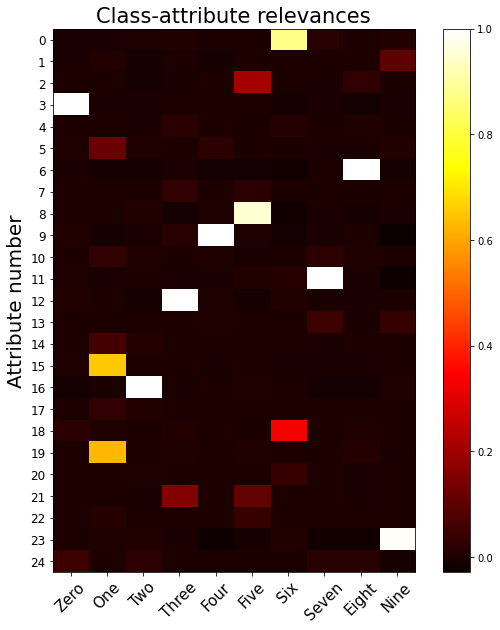

In [77]:
print(global_rel.shape)
def plot_rel(rel, dataset):
    rel2 = 1.0*rel
    if dataset == 'mnist':
        class_name = ['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine']
    elif dataset == 'qdraw':
        class_name = ['Ant', 'Apple', 'Banana', 'Carrot', 'Cat', 'Cow', 'Dog', 'Frog', 'Grapes', 'Lion']
    elif dataset == 'fmnist':
        class_name = ['Ant', 'Apple', 'Banana', 'Carrot', 'Cat', 'Cow', 'Dog', 'Frog', 'Grapes', 'Lion'] 
    x_pos = np.array(range(rel.shape[1])).astype(str)
    x_pos = np.array(['$\phi_{'+i+'}$' for i in x_pos])
    x_pos_int = np.array([i for i in np.array(range(rel.shape[1]))])

    plt.figure(figsize=(10, 10))
    plt.imshow(rel.T, cmap='hot', aspect=0.6)
    plt.xticks(list(range(rel.shape[0])), class_name, fontsize=15, rotation=45)   
    plt.yticks(list(range(rel.shape[1])), range(rel.shape[1]), fontsize=12, rotation=0)
    plt.ylabel('Attribute number', fontsize=20)
    plt.title('Class-attribute relevances', fontsize=21)
    plt.colorbar()
    plt.show()
    
    return
plot_rel(global_rel, 'mnist')

### Generating Local Interpretations 

Predicted class: 9


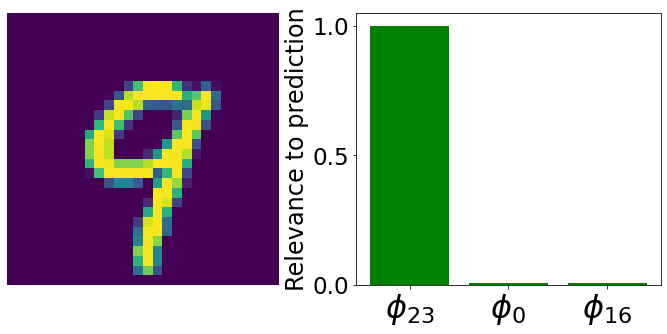

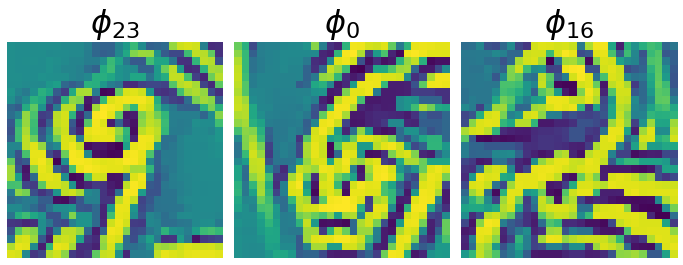

In [78]:
def analyze_img(f, g, h, d, idx, n_attr=3, save=False, location=None):
    f_copy, g, d = f.eval(), g.eval(), d.eval()
    init_img = test_data[idx][0].unsqueeze(0)

    init_shape = init_img.shape
    img = init_img[0, 0].cpu().data.numpy()

    # Complete the computations
    output, inter = f_copy(init_img)
    embed1 = g(inter)
    weights = h.fc1.weight.cpu().data.numpy()
    pred = h(embed1).argmax(dim=1).cpu().data.numpy()
    print ("Predicted class:", pred[0])
    expl1 = embed1[0].cpu().data.numpy() * weights[pred[0]]
    expl1 = expl1 / np.abs(expl1).max()
    attr_idx1 = expl1.argsort()[-1]
    attr_idx2 = expl1.argsort()[-2]
    attr_idx3 = expl1.argsort()[-3]
    cur_img1 = optimize_inp(f_copy, g, attr_idx1, device, list(init_img.shape), init=0.2*init_img, lmbd_bound=10.0, lmbd_tv=6.0, C=2.0, lmbd_l1=0.0)
    cur_img2 = optimize_inp(f_copy, g, attr_idx2, device, list(init_img.shape), init=0.2*init_img, lmbd_bound=10.0, lmbd_tv=6.0, C=2.0, lmbd_l1=0.0)
    cur_img3 = optimize_inp(f_copy, g, attr_idx3, device, list(init_img.shape), init=0.2*init_img, lmbd_bound=10.0, lmbd_tv=6.0, C=2.0, lmbd_l1=0.0)

    # Make the plot
    fig = plt.figure(figsize=(12, 5))
    fig.add_subplot(1, 2, 1)
    plt.imshow(img)
    #plt.title('Input sample', fontsize=28)
    plt.axis('off')

    fig.add_subplot(1, 2, 2)
    x_pos = np.array(range(expl1.shape[0])).astype(str)
    x_pos = np.array(['$\phi_{'+i+'}$' for i in x_pos])
    plt.bar(list(range(n_attr)), -1*np.sort(-1*expl1)[:n_attr], color='green')
    plt.xticks(list(range(n_attr)), x_pos[np.array([attr_idx1, attr_idx2, attr_idx3])], fontsize=32)
    plt.yticks([0, 0.5, 1], [0.0, 0.5, 1.0], fontsize=23)
    plt.ylabel('Relevance to prediction', fontsize=24)
    #plt.subplots_adjust(wspace=0.05)
    if not save:
        plt.show()
    else:
        plt.savefig(location + '/s' + str(idx) + '_rel_')
        plt.close()

    fig = plt.figure(figsize=(12, 5))
    fig.add_subplot(1, 3, 1)
    plt.imshow(cur_img1[0, 0])
    plt.axis('off')
    plt.title('$\phi_{'+str(attr_idx1)+'}$', fontsize=32)
    fig.add_subplot(1, 3, 2)
    plt.imshow(cur_img2[0, 0])
    plt.axis('off')
    plt.title('$\phi_{'+str(attr_idx2)+'}$', fontsize=32)
    fig.add_subplot(1, 3, 3)
    plt.imshow(cur_img3[0, 0])
    plt.axis('off')
    plt.title('$\phi_{'+str(attr_idx3)+'}$', fontsize=32)
    plt.subplots_adjust(wspace=0.05)
    if not save:
        plt.show()
    else:
        plt.savefig(location + '/s' + str(idx) + '_att3_')
        plt.close()
 
    return cur_img1, cur_img2

im1, im2 = analyze_img(f, g, h, d, 12, n_attr=3, save=False, location=None)


Predicted class: 9


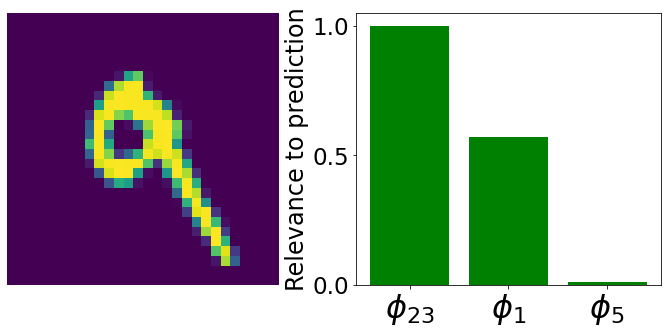

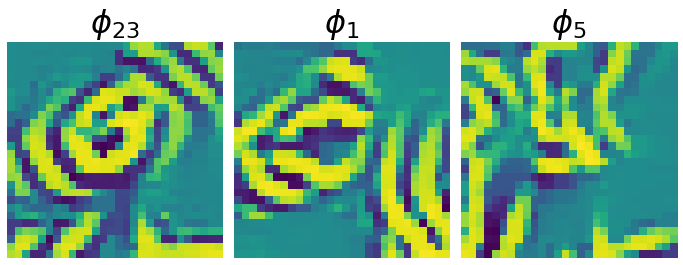

In [79]:
im1, im2 = analyze_img(f, g, h, d, 7, n_attr=3, save=False, location=None)